Questions for TA
- do we need kfold 

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.svm import SVC
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score,recall_score,f1_score, fbeta_score
from sklearn.utils.multiclass import unique_labels

matplotlib.rcParams.update({'font.size': 14})

In [58]:
df = pd.read_csv("../data/heart.csv")



cholest = df['RestingBP'].values
cholest = cholest.astype('float')
cholest[cholest==0] = np.nan
# convert back into a pd dataframe to append to original df
cholesterol = pd.DataFrame(cholest)
rBP = cholesterol.set_axis(['RestingBP'], axis =1)
df.drop('RestingBP',axis=1,inplace=True)

#replace missing values in Cholesterol, RestingBP with np.nan
cholest = df['Cholesterol'].values
cholest = cholest.astype('float')
cholest[cholest==0] = np.nan
# convert back into a pd dataframe to append to original df
cholesterol = pd.DataFrame(cholest)
cholesterol = cholesterol.set_axis(['Cholesterol'], axis =1)
df.drop('Cholesterol',axis=1,inplace=True)
list = [rBP, cholesterol, df]
df_new = pd.concat(list, axis = 1, ignore_index = False)

df1=df_new

X = df_new.iloc[:, :-1]
y = df_new['HeartDisease']

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

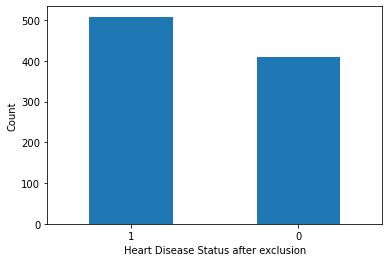

In [2]:
y.value_counts().plot(kind='bar')
plt.xlabel('Heart Disease Status after exclusion')
plt.ylabel('Count')
plt.xticks(rotation=0)


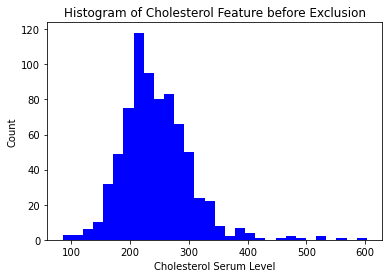

In [3]:
plt.hist(df1["Cholesterol"], color = 'blue', bins=int(np.sqrt(df.shape[0])))
plt.xlabel("Cholesterol Serum Level")
plt.ylabel("Count")
plt.title("Histogram of Cholesterol Feature before Exclusion")
plt.savefig('../figures/beforeexclusioncholesterol.pdf')


## Methods

##### imputation strats

for each model, apply reduced features on subsets created by missingness patterns

train on data with missing values
-xgboost on missing data itself


##### Models
random forest classifier

svm rbf classifier

xgboost

can look @ others time permitting

##### Results
accuracy
 
f_$\beta$

confusion matrix

In [60]:
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# designate a random seed for reproducibility
random_seed = 34   

# initial split to generate the train group
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size=0.6, random_state = random_seed)
# second split to generate the test and validation groups 
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, random_state = random_seed)
X_val, y_val, X_test, y_test

#collect features
std_ftrs = ['Cholesterol', 'RestingBP','MaxHR', 'Oldpeak', 'Age']
onehot_ftrs = ['Sex', 'FastingBS', 'ST_Slope', 'ExerciseAngina', 'RestingECG']
ordinal_ftrs = ['ChestPainType']
ordinal_cats = [['ASY', 'NAP', 'ATA', 'TA']]

# one-hot encoder
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
standard_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(transformers=[
        ('std', standard_transformer, std_ftrs),
        ('onehot', onehot_transformer, onehot_ftrs),
        ('ordinal', ordinal_transformer, ordinal_ftrs)])


X_train_ = preprocessor.fit_transform(X_train)

feature_names = preprocessor.transformers_[0][-1] + \
               preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
df_train = pd.DataFrame(data=X_train_,columns=feature_names)


X_val_ = preprocessor.transform(X_val)
df_CV = pd.DataFrame(data=X_val_,columns = feature_names)

X_test_ = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=X_test_,columns = feature_names)

file = open('../data/preprocessed.save', 'wb')
pickle.dump((feature_names, df_train, df_CV, df_test),file)
file.close()

In [63]:
mask = df_test[['Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak', 'Age', 'Sex_F', 'Sex_M',
       'FastingBS_0', 'FastingBS_1', 'ST_Slope_Down', 'ST_Slope_Flat',
       'ST_Slope_Up', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ChestPainType']].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
for i in range(len(counts)):
    print(unique_rows[i],counts[i])

[False False False False False False False False False False False False
 False False False False False False] 151
[ True False False False False False False False False False False False
 False False False False False False] 33
[151  33]


# XGBoost

In [103]:
nr_state = 10
accuracy_scores = []
y_test_vals = []
all_y_test_vals = []
auc_curve = []

In [104]:

def xgb_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    XGB = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=1)     # initialize XGB
    
    # find the best parameter set
    param_grid = {"learning_rate": [.1, 0.05,.01],
                  "n_estimators": range(60, 220, 40),
                  "missing": [np.nan], 
                  'max_depth': range(2, 10, 1),
                 }
    pg = ParameterGrid(param_grid)

    train_scores = np.zeros(len(pg))
    valid_scores = np.zeros(len(pg))
    test_scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        XGB.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        XGB.fit(X_train, Y_train)
        y_CV_pred = XGB.predict(X_CV)
        y_test_pred = XGB.predict(X_test)
        train_scores[i] = XGB.score(X_train, Y_train)
        valid_scores[i] = accuracy_score(y_CV, y_CV_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)
        

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]
    
    # test the model on the test set with best parameter set
    XGB.set_params(**best_params[0])
    XGB.fit(X_train,Y_train)
    
    y_test_pred = XGB.predict(X_test)


    return (accuracy_score(y_test,y_test_pred), y_test_pred, XGB.feature_importances_)

# all the inputs need to be pandas DataFrame
def reduced_feature5(X_train, Y_train, X_CV, y_CV, X_test, y_test, feature_names):
    X_train = pd.DataFrame(data=X_train, columns=feature_names)
    X_CV = pd.DataFrame(data=X_CV, columns=feature_names)
    X_test = pd.DataFrame(data=X_test, columns=feature_names)
    Y_train = pd.DataFrame(data=Y_train)
    y_test = pd.Series(y_test)
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
#     print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
#         print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=int)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = sub_X_test.append(X_test.iloc[j])# append the according X_test row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run log_reg
        sub_y_test_pred = xgb_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=2)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
        
    ROC = roc_auc_score(y_test,all_y_test_pred)
#     print("total ROC AUC:", ROC)
    return total_accuracy, y_test, all_y_test_pred, ROC
def xgb_random(nr_state):
    for i in range(nr_state):
        onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

        # ordinal encoder
        ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

        # standard scaler
        standard_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
        X_other, X_test, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        rf = reduced_feature5(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[0]
        accuracy_scores.append(rf)
        yv = reduced_feature5(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature5(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
        roc = reduced_feature5(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[3]
        auc_curve.append(roc)
        
    return accuracy_scores, y_test_vals, all_y_test_vals, auc_curve


In [125]:
avg_accuracy = np.mean(np.array(xgb_random(nr_state)[0]))
print(f"Mean of Accuracy of XGB across {nr_state} random states is ",avg_accuracy)

std_accuracy = np.std(np.array(xgb_random(nr_state)[0]))
print(f"STD of Accuracy of XGB across {nr_state} random states is ",std_accuracy)
auc_xgb = np.array(xgb_random(nr_state)[3])

Mean of Accuracy of XGB across 10 random states is  0.8594202898550726
STD of Accuracy of XGB across 10 random states is  0.017769329048121545


In [ ]:

file = open('../results/xgb.save', 'wb')
pickle.dump((avg_accuracy, std_accuracy),file)
file.close()
print(f"Mean of Accuracy of XGB across {nr_state} random states is ",avg_accuracy)
print(f"STD of Accuracy of XGB across {nr_state} random states is ",std_accuracy)


In [ ]:
#random forest
accuracy_scores = []
y_test_vals = []
all_y_test_vals = []
auc_curve = []
param_grid = {"max_features": [1, 3, 5, 10],
            "max_depth": [1, 3, 5, 10, 20]}
pg = ParameterGrid(param_grid)
train_scores = np.zeros(len(pg))
valid_scores = np.zeros(len(pg))
test_scores = np.zeros(len(pg))


def clf_rforest(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = RandomForestClassifier(n_jobs=-1)

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        clf.set_params(**params)
        clf.fit(X_train, Y_train)
        y_CV_pred = clf.predict(X_CV)
        y_test_pred = clf.predict(X_test)
        train_scores[i] = clf.score(X_train, Y_train)
        valid_scores[i] = accuracy_score(y_CV, y_CV_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,Y_train)
    
    y_test_pred = clf.predict(X_test)

    return (accuracy_score(y_test,y_test_pred), y_test_pred, clf.feature_importances_)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_rforest(X_train, Y_train, X_CV, y_CV, X_test, y_test, feature_names):
    
    # find all unique patterns of missing value in test set
    X_train=pd.DataFrame(X_train)
    
    X_CV=pd.DataFrame(X_CV)
    
    X_test=pd.DataFrame(X_test)
    
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        #print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = sub_X_test.append(X_test.iloc[j])# append the according X_test row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run rforest
        sub_y_test_pred = clf_rforest(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        #print('   Accuracy:',(accuracy_score(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    #confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score           
    # get global scores
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
    ROC = roc_auc_score(y_test,all_y_test_pred)
    return total_accuracy, y_test, all_y_test_pred, ROC


def rf_random(nr_state):
    for i in range(nr_state):
        onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

        # ordinal encoder
        ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

        # standard scaler
        standard_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
        X_other, X_test, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        rf = reduced_feature_rforest(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[0]
        accuracy_scores.append(rf)
        yv = reduced_feature_rforest(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature_rforest(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
        roc = reduced_feature_rforest(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[3]
        auc_curve.append(roc)
        
    return accuracy_scores, y_test_vals, all_y_test_vals, auc_curve


In [ ]:
average_accuracy_rf = np.mean(np.array(rf_random(nr_state)[0]))
std_accuracy_rf = np.std(np.array(rf_random(nr_state)[0]))
print("Accuracy", average_accuracy)
print("SD", std_accuracy)
auc_rf = np.array(rf_random(nr_state)[3])
file = open('../results/RFC.save', 'wb')
pickle.dump((average_accuracy_rf, std_accuracy_rf),file)
file.close()

# SVC

In [ ]:
#Support Vector Classifier
accuracy_scores = []
y_test_vals = []
all_y_test_vals = []
auc_curve = []
param_grid = {'C': np.linspace(0.1,1,10).tolist(),
              'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
pg = ParameterGrid(param_grid)
train_scores = np.zeros(len(pg))
valid_scores = np.zeros(len(pg))
test_scores = np.zeros(len(pg))
def clf_SVC(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = SVC()

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        clf.set_params(**params)
        clf.fit(X_train, Y_train)
        y_CV_pred = clf.predict(X_CV)
        y_test_pred = clf.predict(X_test)
        train_scores[i] = clf.score(X_train, Y_train)
        valid_scores[i] = accuracy_score(y_CV, y_CV_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,Y_train)
    
    y_test_pred = clf.predict(X_test)

    return (accuracy_score(y_test,y_test_pred), y_test_pred)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_SVC(X_train, Y_train, X_CV, y_CV, X_test, y_test, feature_names):
    
    # find all unique patterns of missing value in test set
    X_train=pd.DataFrame(X_train)
    
    X_CV=pd.DataFrame(X_CV)
    
    X_test=pd.DataFrame(X_test)
    
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        #print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = sub_X_test.append(X_test.iloc[j])# append the according X_test row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run rforest
        sub_y_test_pred = clf_SVC(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        #print('   Accuracy:',(accuracy_score(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    #confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score           
    # get global scores
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
    ROC = roc_auc_score(y_test,all_y_test_pred)
    return total_accuracy, y_test, all_y_test_pred, ROC


def SVC_random(nr_state):
    for i in range(nr_state):
        onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

        # ordinal encoder
        ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

        # standard scaler
        standard_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
        X_other, X_test, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        rf = reduced_feature_SVC(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[0]
        accuracy_scores.append(rf)
        yv = reduced_feature_SVC(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature_SVC(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
        roc = reduced_feature_SVC(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[3]
        auc_curve.append(roc)
        
    return accuracy_scores, y_test_vals, all_y_test_vals, auc_curve


In [ ]:
average_accuracy = np.mean(np.array(SVC_random(nr_state)[0]))

std_accuracy = np.std(np.array(SVC_random(nr_state)[0]))
print("Accuracy", average_accuracy)
print("SD", std_accuracy)
auc_svc = np.array(SVC_random(nr_state)[3])
file = open('../results/SVC.save', 'wb')
pickle.dump((average_accuracy, std_accuracy),file)
file.close()

# LogReg (l1 penalty)

In [127]:
#Logistic Regression with L1 Regularization
accuracy_scores = []
y_test_vals = []
all_y_test_vals = []
auc_curve = []
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
pg = ParameterGrid(param_grid)
train_scores = np.zeros(len(pg))
valid_scores = np.zeros(len(pg))
test_scores = np.zeros(len(pg))

def clf_L1(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(penalty='l1', solver='saga')

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        clf.set_params(**params)
        clf.fit(X_train, Y_train)
        y_CV_pred = clf.predict(X_CV)
        y_test_pred = clf.predict(X_test)
        train_scores[i] = clf.score(X_train, Y_train)
        valid_scores[i] = accuracy_score(y_CV, y_CV_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,Y_train)
    
    y_test_pred = clf.predict(X_test)

    return (accuracy_score(y_test,y_test_pred), y_test_pred)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_L1(X_train, Y_train, X_CV, y_CV, X_test, y_test, feature_names):
    
    # find all unique patterns of missing value in test set
    X_train=pd.DataFrame(X_train)
    
    X_CV=pd.DataFrame(X_CV)
    
    X_test=pd.DataFrame(X_test)
    
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        #print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = sub_X_test.append(X_test.iloc[j])# append the according X_test row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run rforest
        sub_y_test_pred = clf_L1(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        #print('   Accuracy:',(accuracy_score(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    #confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score           
    # get global scores
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
    ROC = roc_auc_score(y_test,all_y_test_pred)
    return total_accuracy, y_test, all_y_test_pred, ROC


def l1_random(nr_state):
    for i in range(nr_state):
        onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

        # ordinal encoder
        ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

        # standard scaler
        standard_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
        X_other, X_test, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        rf = reduced_feature_L1(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[0]
        accuracy_scores.append(rf)
        yv = reduced_feature_L1(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature_L1(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
        roc = reduced_feature_L1(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[3]
        auc_curve.append(roc)
        
    return accuracy_scores, y_test_vals, all_y_test_vals, auc_curve


In [128]:
average_accuracy = np.mean(np.array(l1_random(nr_state)[0]))
std_accuracy = np.std(np.array(l1_random(nr_state)[0]))
print("Accuracy", average_accuracy)
print("SD", std_accuracy)
auc_l1 = np.array(l1_random(nr_state)[3])
file = open('../results/logregl1.save', 'wb')
pickle.dump((average_accuracy, std_accuracy),file)
file.close()

there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Accuracy 0.8614130434782608
SD 0.019329803525846456
there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# LogReg (l2 penalty)

In [129]:
#Logistic Regression with L2 Regularization
accuracy_scores = []
y_test_vals = []
all_y_test_vals = []
auc_curve = []
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
pg = ParameterGrid(param_grid)
train_scores = np.zeros(len(pg))
valid_scores = np.zeros(len(pg))
test_scores = np.zeros(len(pg))

def clf_L2(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(penalty='l2', solver='saga')

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        clf.set_params(**params)
        clf.fit(X_train, Y_train)
        y_CV_pred = clf.predict(X_CV)
        y_test_pred = clf.predict(X_test)
        train_scores[i] = clf.score(X_train, Y_train)
        valid_scores[i] = accuracy_score(y_CV, y_CV_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,Y_train)
    
    y_test_pred = clf.predict(X_test)

    return (accuracy_score(y_test,y_test_pred), y_test_pred)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_L2(X_train, Y_train, X_CV, y_CV, X_test, y_test, feature_names):
    
    # find all unique patterns of missing value in test set
    X_train=pd.DataFrame(X_train)
    
    X_CV=pd.DataFrame(X_CV)
    
    X_test=pd.DataFrame(X_test)
    
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        #print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = sub_X_test.append(X_test.iloc[j])# append the according X_test row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run rforest
        sub_y_test_pred = clf_L2(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        #print('   Accuracy:',(accuracy_score(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    #confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score           
    # get global scores
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
    ROC = roc_auc_score(y_test,all_y_test_pred)
    return total_accuracy, y_test, all_y_test_pred, ROC


def l2_random(nr_state):
    for i in range(nr_state):
        onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

        # ordinal encoder
        ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

        # standard scaler
        standard_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
        X_other, X_test, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        rf = reduced_feature_L2(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[0]
        accuracy_scores.append(rf)
        yv = reduced_feature_L2(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature_L2(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
        roc = reduced_feature_L2(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[3]
        auc_curve.append(roc)
        
    return accuracy_scores, y_test_vals, all_y_test_vals, auc_curve


In [130]:
average_accuracy = np.mean(np.array(l2_random(nr_state)[0]))

std_accuracy = np.std(np.array(l2_random(nr_state)[0]))
print("Accuracy", average_accuracy)
print("SD", std_accuracy)
auc_l2 = np.array(l2_random(nr_state)[3])
file = open('../results/logregl2.save', 'wb')
pickle.dump((average_accuracy, std_accuracy),file)
file.close()

there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


Accuracy 0.8597826086956522
SD 0.017827412463974696
there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 3 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


there are 2 unique missing value patterns.


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [131]:
#Logistic Regression with ElasticNet Regularization
accuracy_scores = []
y_test_vals = []
all_y_test_vals = []
auc_curve = []
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], #logspace(-3,4,7)
             'l1_ratio': [0.01, 0.1, 0.25, 0.5,0.75, 0.9, 0.99]}
pg = ParameterGrid(param_grid)
train_scores = np.zeros(len(pg))
valid_scores = np.zeros(len(pg))
test_scores = np.zeros(len(pg))


def clf_EN(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = LogisticRegression(penalty='elasticnet', solver='saga', max_iter = 1e5)

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        clf.set_params(**params)
        clf.fit(X_train, Y_train)
        y_CV_pred = clf.predict(X_CV)
        y_test_pred = clf.predict(X_test)
        train_scores[i] = clf.score(X_train, Y_train)
        valid_scores[i] = accuracy_score(y_CV, y_CV_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,Y_train)
    
    y_test_pred = clf.predict(X_test)

    return (accuracy_score(y_test,y_test_pred), y_test_pred)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_EN(X_train, Y_train, X_CV, y_CV, X_test, y_test, feature_names):
    
    # find all unique patterns of missing value in test set
    X_train=pd.DataFrame(X_train)
    
    X_CV=pd.DataFrame(X_CV)
    
    X_test=pd.DataFrame(X_test)
    
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        #print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = sub_X_test.append(X_test.iloc[j])# append the according X_test row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run rforest
        sub_y_test_pred = clf_EN(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        #print('   Accuracy:',(accuracy_score(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    #confusion_matrix, precision_score, recall_score, accuracy_score, fbeta_score           
    # get global scores
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
    ROC = roc_auc_score(y_test,all_y_test_pred)
    return total_accuracy, y_test, all_y_test_pred, ROC


def EN_random(nr_state):
    for i in range(nr_state):
        onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

        # ordinal encoder
        ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

        # standard scaler
        standard_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
        X_other, X_test, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        rf = reduced_feature_EN(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[0]
        accuracy_scores.append(rf)
        yv = reduced_feature_EN(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature_EN(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
        roc = reduced_feature_EN(df_train, y_train, df_CV, y_CV, df_test, y_test, feature_names)[3]
        auc_curve.append(roc)
        
    return accuracy_scores, y_test_vals, all_y_test_vals, auc_curve


In [132]:
average_accuracy = np.mean(np.array(EN_random(nr_state)[0]))

std_accuracy = np.std(np.array(EN_random(nr_state)[0]))
print("Accuracy", average_accuracy)
print("SD", std_accuracy)
auc_en = np.array(EN_random(nr_state)[3])
file = open('../results/logregEN.save', 'wb')
pickle.dump((average_accuracy, std_accuracy),file)
file.close()

there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 3 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2 unique missing value patterns.
there are 2

In [133]:
#baseline accuracy
#fill array of ones with len = len(y)
#run accuracy score one ones with y

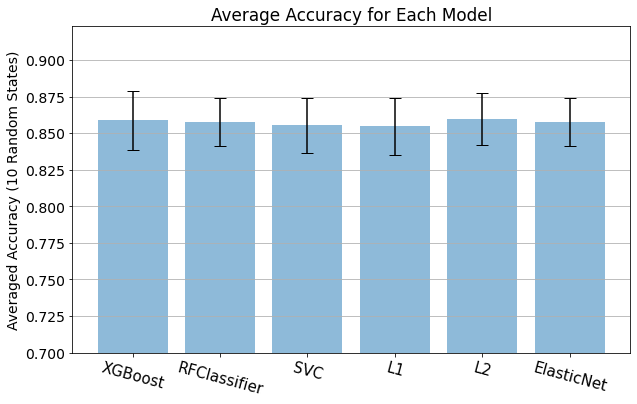

In [134]:
width = 0.3

labels = ["XGBoost", "RFClassifier", "SVC","L1", "L2", "ElasticNet"]

x_pos = np.arange(len(labels))

CTEs = [0.8586956521739131,0.8576086956521738,0.8552536231884058,0.8546739130434783,0.8597826086956522,0.8576086956521738]
error = [0.02033509449333664,0.016627237544324287,0.018706629108147504,0.01932895459181034,0.017827412463974696,0.016627237544324287]

fig, ax = plt.subplots(figsize=(10,6))


ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=6)

ax.set_ylabel('Averaged Accuracy (10 Random States)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation = -15, fontsize = 15)
ax.set_title('Average Accuracy for Each Model')
ax.yaxis.grid(True)

ax.set_ylim(0.7)
plt.savefig('../figures/modelselection1.pdf' )

In [135]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer


def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    std_ftrs = ['Cholesterol', 'RestingBP','MaxHR', 'Oldpeak', 'Age']
    onehot_ftrs = ['Sex', 'FastingBS', 'ST_Slope', 'ExerciseAngina', 'RestingECG']
    ordinal_ftrs = ['ChestPainType']
    ordinal_cats = [['ASY', 'NAP', 'ATA', 'TA']]
    

       # one-hot encoder
    onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

    # ordinal encoder
    ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

    # standard scaler
    standard_transformer = Pipeline(steps=[
        ('imputer2', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])


    preprocessor = ColumnTransformer(transformers=[
            ('std', standard_transformer, std_ftrs),
            ('onehot', onehot_transformer, onehot_ftrs),
            ('ordinal', ordinal_transformer, ordinal_ftrs)])
    final_scaler = StandardScaler()

    pipe = make_pipeline(preprocessor,final_scaler, LogisticRegression(penalty='l2',solver='saga',max_iter=10000000))


# clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

    
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = std_ftrs + \
                grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
    ordinal_ftrs

    return grid, np.array(feature_names), X_test, y_test

test score: 0.8532608695652174
[ 0.03988337  0.03348171 -0.22860961  0.42462872  0.15085506 -0.28061343
  0.28061343 -0.24214768  0.24214768  0.01950248  0.52826252 -0.5449551
 -0.25452396  0.25452396  0.02423571  0.0102253  -0.0374342  -0.53266529]


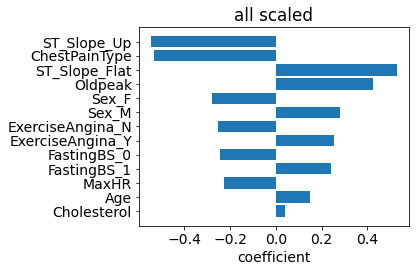

In [139]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold(df_new,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
print(coefs)
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(13),coefs[sorted_indcs[-13:]])
plt.yticks(np.arange(13),feature_names[sorted_indcs[-13:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('../figures/COEFFICIENTS.pdf' )
plt.show()


In [140]:
random_state = 42
def ML_pipeline_kfold1(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    std_ftrs = ['Cholesterol', 'RestingBP','MaxHR', 'Oldpeak', 'Age']
    onehot_ftrs = ['Sex', 'FastingBS', 'ST_Slope', 'ExerciseAngina', 'RestingECG']
    ordinal_ftrs = ['ChestPainType']
    ordinal_cats = [['ASY', 'NAP', 'ATA', 'TA']]
    

       # one-hot encoder
    onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

    # ordinal encoder
    ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

    # standard scaler
    standard_transformer = Pipeline(steps=[
        ('imputer2', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])


    preprocessor = ColumnTransformer(transformers=[
            ('std', standard_transformer, std_ftrs),
            ('onehot', onehot_transformer, onehot_ftrs),
            ('ordinal', ordinal_transformer, ordinal_ftrs)])

    pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators =  100,random_state=random_state))


    param_grid = {'randomforestclassifier__max_depth': [10,30,100,300],
                  'randomforestclassifier__min_samples_split': [16, 32, 64, 128]}
    
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = std_ftrs + \
                grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
    ordinal_ftrs

    return grid, np.array(feature_names), X_test, y_test

In [141]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold1(df_new,y,42,4)

In [142]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(184, 18)
(2, 184, 18)


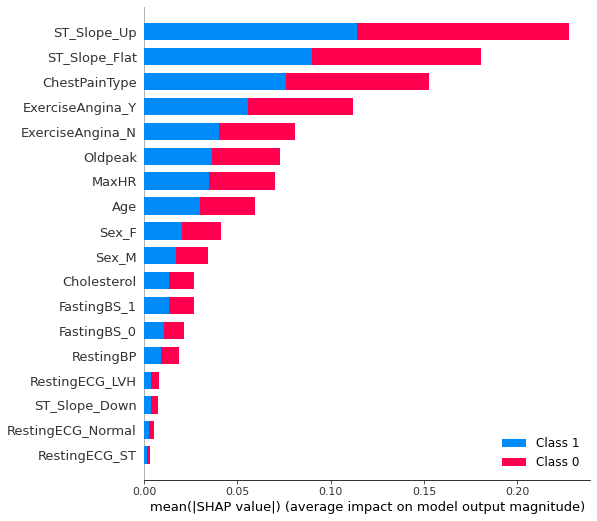

In [143]:
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = feature_names, show=False)
plt.savefig('../figures/shapsummary2.pdf' )

In [144]:
index = 1 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_transformed[index,:],feature_names = feature_names, show=False)
plt.savefig('../figures/shapsummary2.pdf' )


0.4506811989100817


<Figure size 432x288 with 0 Axes>

In [145]:
grid, features, X_test, y_test = ML_pipeline_kfold(df_new,y,42,4)
np.random.seed(42)

ftr_names = df_new.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 1)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8532608695652174
test baseline =  0.5815217391304348
shuffling RestingBP
   shuffled test score: 0.857 +/- 0.007
shuffling Cholesterol
   shuffled test score: 0.855 +/- 0.005
shuffling Age
   shuffled test score: 0.857 +/- 0.004
shuffling Sex
   shuffled test score: 0.824 +/- 0.006
shuffling ChestPainType
   shuffled test score: 0.815 +/- 0.012
shuffling FastingBS
   shuffled test score: 0.822 +/- 0.011
shuffling RestingECG
   shuffled test score: 0.859 +/- 0.004
shuffling MaxHR
   shuffled test score: 0.842 +/- 0.005
shuffling ExerciseAngina
   shuffled test score: 0.838 +/- 0.013
shuffling Oldpeak
   shuffled test score: 0.855 +/- 0.008
shuffling ST_Slope
   shuffled test score: 0.753 +/- 0.025
shuffling HeartDisease
   shuffled test score: 0.853 +/- 0.0


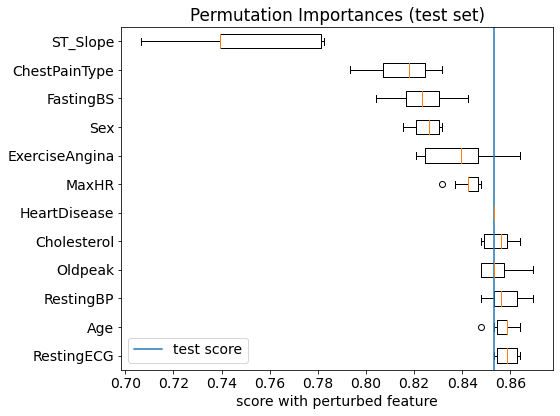

In [146]:
ftr_names = df_new.columns
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/permutationimportances.pdf' )
plt.show()

In [149]:
index = 100 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_transformed[index,:],feature_names = feature_names)
#plt.savefig('../figures/shapsummary.pdf' )


0.4506811989100817


- ROC curve for each model 
Rf/SVC/XGB
p_crits = linspace(0,1)
if the predict_proba for each sample is 


-measuring uncertainty of random models (RF/XGB)
 -try different random stats and ensure that models return similar values but you don't want 0 variance
 
 
- parameters of best model is 1 measure of global feature importance (10000 estimators, max_depth=50, sfsdf)
- SHAP
- Permutation IMportance
- Feature Importances 

In [150]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [151]:
# to create confusion matrix



nr_state = 100
accuracy_scores = []
auc_curve = []
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
pg = ParameterGrid(param_grid)
train_scores = np.zeros(len(pg))
valid_scores = np.zeros(len(pg))
test_scores = np.zeros(len(pg))



def logreg_model_con(X_train1, Y_train1, X_CV1, y_CV1, X_test1, y_test, verbose=1):
    # make into row vectors to avoid an obnoxious sklearn warning
    Y_train1 = np.reshape(np.array(Y_train1), (1, -1)).ravel()
    y_CV1 = np.reshape(np.array(y_CV1), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()
    
    clf = LogisticRegression(penalty='l2', solver='saga', random_state = 42)    # find the best parameter set

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        clf.set_params(**params)
        clf.fit(X_train1, Y_train1)
        y_CV1_pred = clf.predict(X_CV1)
        y_test_pred = clf.predict(X_test1)
        train_scores[i] = clf.score(X_train1, Y_train1)
        valid_scores[i] = accuracy_score(y_CV1, y_CV1_pred)
        test_scores[i] = accuracy_score(y_test, y_test_pred)
        

    best_params = np.array(pg)[valid_scores == np.max(valid_scores)]
    
    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train1, Y_train1)

    y_test_pred = clf.predict(X_test1)
    param_test = accuracy_score(y_test, y_test_pred)

    return (accuracy_score(y_test,y_test_pred), y_test_pred)

    


# all the inputs need to be pandas DataFrame
def reduced_feature_con(X_train1, Y_train1, X_CV1, y_CV1, X_test1, y_test, feature_names):
    X_train1 = pd.DataFrame(data=X_train1, columns=feature_names)
    X_CV1 = pd.DataFrame(data=X_CV1, columns=feature_names)
    X_test1 = pd.DataFrame(data=X_test1, columns=feature_names)
    Y_train1 = pd.DataFrame(data=Y_train1)
    y_test = pd.Series(y_test)
    # find all unique patterns of missing value in test set
    mask = X_test1.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    all_y_test = pd.DataFrame()
    

    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        ## generate X_test1 subset that matches the unique pattern i
        sub_X_test1 = pd.DataFrame()
        sub_y_test = pd.Series(dtype=int)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test1 = sub_X_test1.append(X_test1.iloc[j])# append the according X_test1 row j to the subset
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])# append the according y_test row j
        sub_X_test1 = sub_X_test1[X_test1.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train1 = pd.DataFrame()
        sub_Y_train1 = pd.DataFrame()
        sub_X_CV1 = pd.DataFrame()
        sub_y_CV1 = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test1
        sub_X_train1 = X_train1[X_train1.columns[~unique_rows[i]]]
        sub_X_CV1 = X_CV1[X_CV1.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train1 and sub_X_CV1 that have any nans
        sub_X_train1 = sub_X_train1.dropna()
        sub_X_CV1 = sub_X_CV1.dropna()   
        # 3.cut the sub_Y_train1 and sub_y_CV1 accordingly
        sub_Y_train1 = Y_train1.iloc[sub_X_train1.index]
        sub_y_CV1 = y_CV1.iloc[sub_X_CV1.index]
        
        
        # run log_reg
        sub_y_test_pred = logreg_model_con(sub_X_train1, sub_Y_train1, sub_X_CV1, 
                                       sub_y_CV1, sub_X_test1, sub_y_test, verbose=2)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        # collect the test predictions
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    # get global RMSE
    total_accuracy =  accuracy_score(y_test,all_y_test_pred)
    ROC = roc_auc_score(y_test,all_y_test_pred)
    return total_accuracy, y_test, all_y_test_pred, ROC

def pipeline_random_con():
    y_test_vals = []
    all_y_test_vals = []
    for i in range(nr_state):
        X_other, X_test1, y_other, y_test = train_test_split(df_new, y, test_size=0.2, random_state=15*i)
        X_train1, X_CV1, Y_train1, y_CV1 = train_test_split(X_other, y_other, test_size=0.25, random_state=15*i)
        preprocessor = ColumnTransformer(transformers=[
                        ('std', standard_transformer, std_ftrs),
                        ('onehot', onehot_transformer, onehot_ftrs),
                        ('ordinal', ordinal_transformer, ordinal_ftrs)])

        X_prep = preprocessor.fit_transform(X_train1)
    

        feature_names = preprocessor.transformers_[0][-1] + \
                        preprocessor.named_transformers_['onehot'][0].get_feature_names(onehot_ftrs).tolist() + \
                preprocessor.transformers_[2][-1]
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
#         print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV1)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
#         print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test1)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
#         print(df_test.shape)
        yv = reduced_feature_con(df_train, Y_train1, df_CV, y_CV1, df_test, y_test, feature_names)[1]
        y_test_vals.append(yv)
        at = reduced_feature_con(df_train, Y_train1, df_CV, y_CV1, df_test, y_test, feature_names)[2]
        all_y_test_vals.append(at)
#         roc = reduced_feature3(df_train, Y_train1, df_CV, y_CV1, df_test, y_test, feature_names)[3]
#         auc_curve.append(roc)
        
    return y_test_vals, all_y_test_vals


In [152]:
ys = pipeline_random_con()[0]
preds = pipeline_random_con()[1]

confusion_y = np.array(ys).ravel()
confusion_y_pred = np.array(preds).ravel()
print(len(confusion_y))
print(len(confusion_y_pred))
C = confusion_matrix(confusion_y,confusion_y_pred) 

tpr = C[1,1]/(C[1,0]+C[1,1])
fpr = C[0,1]/(C[0,0]+C[0,1])

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

18400
18400


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


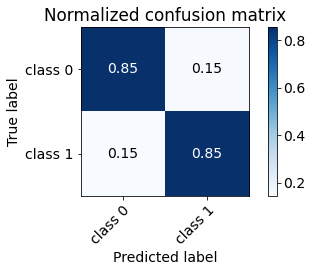

In [153]:
plot_confusion_matrix(confusion_y,confusion_y_pred,classes=['class 0','class 1'],normalize=True)
plt.savefig('../figures/confusionmatrix.pdf', bbox_inches = "tight")
plt.show()
